In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mediapipe as mp

from dataset import DatasetKeypoints

# 1. Data

[Dataset link](http://domedb.perception.cs.cmu.edu/handdb.html)

Пусть структура нашей выборки будет представлять из себя кортеж с изображением и набором ключевых точек обеих рук, сначала левой, затем правой.

In [2]:
test_ds_path = './data/hand_labels/manual_test'
test_ds = DatasetKeypoints(test_ds_path, img_size=224)

  0%|          | 0/846 [00:00<?, ?it/s]

torch.Size([3, 224, 224])
torch.Size([42, 3])


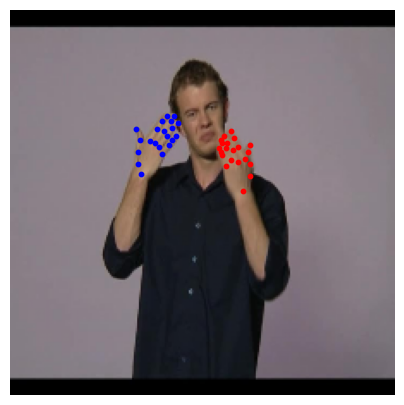

In [3]:
tens_img, tens_lbl = test_ds[1]

print(tens_img.shape)
print(tens_lbl.shape)


fig, ax = plt.subplots(figsize=(5, 5))

dots = tens_lbl.numpy()[:, :-1].astype(int)
plt.imshow(tens_img.numpy().transpose(1, 2, 0))
plt.scatter(dots[:, 0][:21], dots[:, 1][:21], s=10, c='r')
plt.scatter(dots[:, 0][21:], dots[:, 1][21:], s=10, c='b')

plt.axis('off')
plt.show()

# 2. Mediapipe Model

In [106]:
class MediapipeModel:
    def __init__(self):
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(
            static_image_mode=True,
            max_num_hands=2
        )

    @staticmethod
    def _collect_keypoints(res):
        st_keypoints = np.vstack([
            [
                [finger.x, finger.y]
                for finger in res.multi_hand_landmarks[1].landmark
            ],
            [
                [finger.x, finger.y]
                for finger in res.multi_hand_landmarks[0].landmark
            ]
        ]) * 224
        return st_keypoints.astype(int)
        
    def __call__(self, img: np.array):
        res = self.hands.process(img)
        kps = self._collect_keypoints(res)
        return kps

In [107]:
mediapipe_model = MediapipeModel()

In [108]:
array_img = (
    tens_img.numpy().transpose(1, 2, 0) * 255
).astype('uint8')

In [109]:
st_kps = mediapipe_model(array_img)
st_kps.shape

(42, 2)

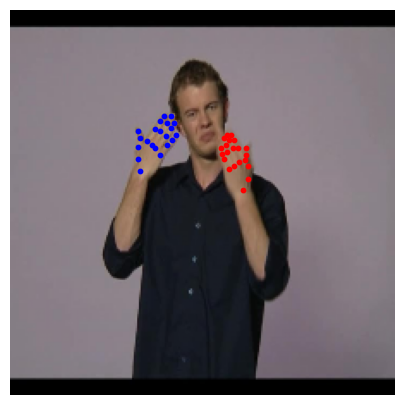

In [110]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.imshow(tens_img.numpy().transpose(1, 2, 0))
plt.scatter(st_kps[:, 0][:21], st_kps[:, 1][:21], s=10, c='r')
plt.scatter(st_kps[:, 0][21:], st_kps[:, 1][21:], s=10, c='b')

plt.axis('off')
plt.show()